In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score, accuracy_score, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import visuals as vs
import time

# DataFrame import and preparation

In [25]:
df = pd.read_csv('Dataframe raw.csv', sep = ';')
df_final = pd.read_csv('DataFrame.csv', sep = ';', index_col = 0)

In [26]:
#separation of input and output for the second model
df_input = df_final.iloc[:,1:16].drop(['ES Service'], axis= 1) #drop service
df_middle = df_final.iloc[:,16:]

#input features from the first stage that are also added as input in the second stage
added_to_second = ['DS Discover', 'DS Define','DS Develop','DS Deliver', 'ES Product', 'Team size min',
                   'Part Users', 'Part Experts', 'Part Service staff', 'Part Stakeholders']

df_middle_second = pd.concat([df_middle, df_final[added_to_second]], axis = 1) #used as input in this stage

mapping_names = {name['Name']: index for index, name in df.iterrows()}
df_output = df_final['Name'].map(mapping_names) #used as output in this stage

scores = pd.DataFrame(index = ['Scores'], columns = ['SSD Mean', 'SSD std', 'Max Mean', 'Max std', 'Probas Sum Mean',
                                                     'Probas Sum std', 'Empty outputs', 'Acc Mean'])

In [27]:
#check which models have predict_proba function
'''from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)
'''

"from sklearn.utils.testing import all_estimators\n\nestimators = all_estimators()\n\nfor name, class_ in estimators:\n    if hasattr(class_, 'predict_proba'):\n        print(name)\n"

# Functions

In [28]:
#generates stratified (proportional to each class) train and test splits 
from sklearn.model_selection import StratifiedShuffleSplit

def splitter(random_state):
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=random_state)

    for train_index, test_index in sss.split(df_middle_second, df_output):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_prod, X_test_prod = df_middle_second.iloc[train_index], df_middle_second.iloc[test_index]
        y_train_prod, y_test_prod = df_output.iloc[train_index], df_output.iloc[test_index]
    return X_train_prod, X_test_prod, y_train_prod, y_test_prod

#X_train_prod, X_test_prod, y_train_prod, y_test_prod = splitter(0)

In [29]:
#scorer used in this second stage
# SSD - sum of squared distances - measures how far the three probas are from each other. Farther values penalize this metric
# Max - maximal value of probability among the three probas
# Probas sum - sum of three probas (probas for all CITs should add 1)
# Empty outputs - number of cases in which no CIT achieved a threshold of 0.01 (1% of probability)
# Acc - percentage of executions that resulted in one of the chosen CIT being the truth value

def scorer_second_stage(predictions, y_values, tol = 0.5):
    scores = pd.DataFrame(index = ['Scores'], columns = ['SSD Mean', 'SSD std', 'Max Mean', 'Max std', 'Probas Sum Mean',
                                                         'Probas Sum std', 'Empty outputs', 'Acc Mean'])
    name = df.loc[:,'Name']

    predictions_df = pd.DataFrame(0, index = y_values.index.values, columns = name)
    predictions_df += predictions #translates the predict_proba values to a DF

    #creates an empty DF to retain score
    score_table = pd.DataFrame(index = y_values.index.values, columns = ['Truth value', 'First', '1st Proba', 'Second', '2nd Proba',
                                                                             'Third', '3rd Proba', 'Probas Sum', 'SSD', 'Accuracy'])

    score_table['Truth value'] = y_values #fill the Truth value column for scoring

    remapping_names = {index: name['Name'] for index, name in df.iterrows()}
    score_table['Truth value'] = score_table['Truth value'].map(remapping_names)

    count = 0
    for index, row in predictions_df.iterrows():
        #fill the Predicted names column for scoring with the best 3 CITs according to predictions_df
        score_table.loc[index, ['First', 'Second', 'Third']] = np.array(sorted(zip(row, name), reverse=True)[:3])[:,1]
        #fill the Predicted values column for scoring with the best 3 scores in the predictions_df
        score_table.loc[index, ['1st Proba', '2nd Proba', '3rd Proba']] = np.array(sorted(zip(row, name), reverse=True)[:3])[:,0].astype(np.float)

        #remove items that did not reach a certain tolerance:
        for item in ['1st Proba', '2nd Proba', '3rd Proba']:
            if (score_table.loc[index, item] < tol):
                score_table.loc[index, item] = 0
                previous_column = score_table.iloc[:,np.where(score_table.columns == item)[0]-1].columns[0]
                score_table.loc[index, previous_column] = 0

        #compute mean values:
        values = score_table.loc[index, ['1st Proba', '2nd Proba', '3rd Proba']]
        score_table.loc[index, 'Probas Sum'] = np.sum(values)
        score_table.loc[index, 'SSD'] = np.sum((values-np.mean(values))**2)

    #check if best CIT (from Truth value) is inside the best 3 predicted CITs
    empty_predictions = 0
    for i, row in score_table.iterrows():
        if row['Truth value'] in list(row[['First', 'Second', 'Third']]):
            score_table.loc[i, 'Accuracy'] = 1
        else:
            score_table.loc[i, 'Accuracy'] = 0
        #check if any predictions ended up empty
        empty_predictions += sum([row[['First', 'Second', 'Third']] == 0][0])

    scores.loc['Scores'] = [np.mean(score_table['SSD']), np.std(score_table['SSD']),
                            np.mean(score_table['1st Proba']), np.std(score_table['1st Proba']),
                            np.mean(score_table['Probas Sum']), np.std(score_table['Probas Sum']),
                            empty_predictions, np.mean(score_table['Accuracy'])]
    return score_table, scores

In [30]:
#aggregative function for multioutput classification returning directly the scoring of the model

from sklearn.multioutput import MultiOutputClassifier

def model_fit_predict(model, random_state, tol):
    
    X_train_prod, X_test_prod, y_train_prod, y_test_prod = splitter(random_state)
    
    model.fit(X_train_prod, y_train_prod)
    predictions_train = model.predict_proba(X_train_prod)
    predictions_test = model.predict_proba(X_test_prod)
    score_table_train, scores_train = scorer_second_stage(predictions_train, y_train_prod, tol)
    score_table_test, scores_test = scorer_second_stage(predictions_test, y_test_prod, tol)
    
    return score_table_train, score_table_test, scores_train, scores_test

# Models testing
all models bellow were tested withou any parameters and than with one parameter to check improvements of the metrics

# KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors= 20)

start = time.time()

score_table_train_knn, score_table_test_knn, scores_train_knn, scores_test_knn = model_fit_predict(model, int(time.time()), 0.01)

time.time() - start

7.260499954223633

In [9]:
scores_train_knn

,SSD Mean,SSD std,Max Mean,Max std,Probas Sum Mean,Probas Sum std,Empty outputs,Acc Mean
Scores,0.237139,0.223606,0.650995,0.204122,0.983333,0.0404678,206,1


In [10]:
scores_test_knn

,SSD Mean,SSD std,Max Mean,Max std,Probas Sum Mean,Probas Sum std,Empty outputs,Acc Mean
Scores,0.218395,0.227872,0.628148,0.209374,0.98037,0.0479569,63,1


# DecisionTree

In [11]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 5)

start = time.time()

score_table_train_DT, score_table_test_DT, scores_train_DT, scores_test_DT = model_fit_predict(model, int(time.time()), 0.01)

time.time() - start

7.524832248687744

In [12]:
scores_train_DT

,SSD Mean,SSD std,Max Mean,Max std,Probas Sum Mean,Probas Sum std,Empty outputs,Acc Mean
Scores,0.372044,0.330506,0.624378,0.421371,0.723881,0.30975,448,0.723881


In [13]:
scores_test_DT

,SSD Mean,SSD std,Max Mean,Max std,Probas Sum Mean,Probas Sum std,Empty outputs,Acc Mean
Scores,0.356155,0.331951,0.60412,0.423214,0.708989,0.311104,144,0.703704


# SVC

In [14]:
from sklearn.svm import SVC

model = SVC(probability = True, C = 1000)

start = time.time()

score_table_train_SVC, score_table_test_SVC, scores_train_SVC, scores_test_SVC = model_fit_predict(model, int(time.time()), 0.01)

time.time() - start

5.997016906738281

In [15]:
scores_train_SVC

,SSD Mean,SSD std,Max Mean,Max std,Probas Sum Mean,Probas Sum std,Empty outputs,Acc Mean
Scores,0.258515,0.0949496,0.65463,0.116652,0.749392,0.0800784,0,1


In [16]:
scores_test_SVC

,SSD Mean,SSD std,Max Mean,Max std,Probas Sum Mean,Probas Sum std,Empty outputs,Acc Mean
Scores,0.258019,0.092459,0.653947,0.115046,0.747139,0.0799056,0,1


# Logistic Reg

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', C = 0.5)

start = time.time()

score_table_train_LR, score_table_test_LR, scores_train_LR, scores_test_LR = model_fit_predict(model, int(time.time()), 0.01)

time.time() - start

4.8453638553619385

In [18]:
scores_train_LR

,SSD Mean,SSD std,Max Mean,Max std,Probas Sum Mean,Probas Sum std,Empty outputs,Acc Mean
Scores,0.23759,0.139315,0.635152,0.167731,0.788729,0.103569,5,0.985075


In [19]:
scores_test_LR

,SSD Mean,SSD std,Max Mean,Max std,Probas Sum Mean,Probas Sum std,Empty outputs,Acc Mean
Scores,0.226552,0.135785,0.623402,0.166092,0.779608,0.104235,1,0.985185


# LogReg parameters optimization

In [31]:
from sklearn.linear_model import LogisticRegression

Cs = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 4, 6, 8, 10]
iterations = 10
score_train_n = pd.DataFrame(0, index = Cs, columns = scores.columns.values)
score_test_n = pd.DataFrame(0, index = Cs, columns = scores.columns.values)

for i in range(iterations):
    start = time.time()
    #scores_train_logreg1 = scores_train_logreg
    #scores_test_logreg1 = scores_test_logreg
    for C in Cs:
        model = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', C = C)
        score_table_train_logreg, score_table_test_logreg, scores_train_logreg, scores_test_logreg = model_fit_predict(model, i, 0.01)
        #scores_train_knn.rename(index={'Scores':n}, inplace=True)
        #scores_train_knn.rename(index={'Scores':n}, inplace=True)
        score_train_n.loc[C] += scores_train_logreg.loc['Scores']
        score_test_n.loc[C] += scores_test_logreg.loc['Scores']
    print(time.time()-start)
    
score_train_n = score_train_n/iterations
score_test_n = score_test_n/iterations

57.38473629951477
54.04148626327515
48.627907276153564
48.68859505653381
50.076878786087036
52.32153058052063
55.08250832557678
51.849339723587036
52.39202833175659
59.088940382003784


In [35]:
score_table_test_logreg

,Truth value,First,1st Proba,Second,2nd Proba,Third,3rd Proba,Probas Sum,SSD,Accuracy
187,Functional Analysis,Functional Analysis,0.967151,0,0,0,0,0.967151,0.623587,1
477,Storyboard,Storyboard,0.986064,0,0,0,0,0.986064,0.648214,1
140,Mind Map,Mind Map,0.942889,5 Whys,0.0190537,Impact Matrix,0.0132263,0.975169,0.572593,1
226,5 Whys,5 Whys,0.972061,0,0,0,0,0.972061,0.629935,1
262,5 Whys,5 Whys,0.923209,Mind Map,0.0313477,How Might We,0.0140568,0.968614,0.540758,1
458,Blueprint,Blueprint,0.988734,0,0,0,0,0.988734,0.65173,1
128,5 Whys,5 Whys,0.903434,Mind Map,0.0441323,How Might We,0.0165653,0.964132,0.508565,1
220,Shadowing,Shadowing,0.968475,0,0,0,0,0.968475,0.625296,1
191,Affinity Diagram,Affinity Diagram,0.944949,Dot Voting,0.0150339,How Might We,0.0104625,0.970445,0.579342,1
304,Storyboard,Storyboard,0.978864,0,0,0,0,0.978864,0.638783,1


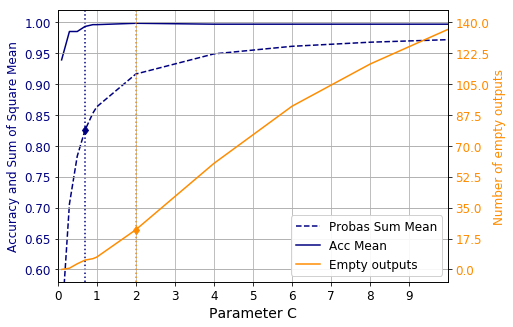

In [60]:
x = score_test_n.index
PSM = score_test_n.loc[:,'Probas Sum Mean']
Acc = score_test_n.loc[:,'Acc Mean']
EO = score_test_n.loc[:,'Empty outputs']

#plt.plot(x, score_test_n.loc[:,'SSD Mean'], markevery = np.where(score_test_n.loc[:,'SSD Mean'] < 0.1))
fig, ax1 = plt.subplots()
fig.set_size_inches(7, 5, forward=True)

plt.xticks(np.arange(0, 10, step=1), fontsize = 12)
plt.xlim([0,10])

#Plotting PMS and Acc
c = 'navy'
lns1 = ax1.plot(x, PSM, c = c, linestyle = '--', linewidth = 1.5)
lns2 = ax1.plot(x, Acc, c = c)
ax1.set_xlabel('Parameter C', fontsize = 14)
#ax1.set_ylabel('Acc rate / Sum of probabilities', color=c)
ax1.tick_params(axis='y', labelcolor=c)

plt.yticks(np.arange(0.6, 1.01, step=0.05), fontsize = 12)
plt.ylim([0.58,1.02])

'''xy = next((x[0]+1,x[1]) for x in enumerate(Acc) if x[1] > 0.91)
ax1.plot(xy[0], xy[1], 'd', c = c)
plt.axvline(x=xy[0], ls=':', c=c)'''

xy = [(i,x) for i,x in PSM.iteritems() if x > 0.8][0]
ax1.plot(xy[0], xy[1], 'd', c = c)
plt.ylabel('Accuracy and Sum of Square Mean', fontsize = 12, color = c)
plt.axvline(x=xy[0], ls=':', c=c)

plt.grid(True)

#Plotting EO
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
c = 'darkorange'
lns3 = ax2.plot(x, EO, color = c)
#ax2.set_ylabel('Empty outputs', color=c)
ax2.tick_params(axis='y', labelcolor=c)
plt.yticks(np.arange(0, 143.75, step=17.5), fontsize = 12)
plt.ylim([-7,147])


xy = [(i,x) for i,x in EO.iteritems() if x > 7][0]
ax2.plot(xy[0], xy[1], 'd', c=c)
plt.ylabel('Number of empty outputs', fontsize = 12, color = c)
plt.axvline(x=xy[0], ls=':', c=c)

plt.grid(True)

#Plotting legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower right', framealpha=.9, fontsize = 12)

plt.savefig('Images/Second stage compound plot.png', dpi = 300, bbox_inches  = 'tight')